This notebook is used for task2 and task4. The purpose of task2 is the implementation of the algorithm and the learning and evaluation pipeline. The purpose of task4 is to do experiments by changing certain terms in the environment configuration and observing the results.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import pickle
import os

import highway_env
import gymnasium as gym

import reinforce
from utils import *

In [2]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No GPU available, using CPU.")

GPU is available!
GPU name: NVIDIA GeForce RTX 3090


We configure our environment.

In [3]:
with open("../configs/config2.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("racetrack-v0", config=config, render_mode="rgb_array")
env.action_space

Box(-1.0, 1.0, (1,), float32)

We specify the training setup and prepare our vectorized environment for the evaluation.

In [ ]:
n_eval = 20
eval_every = 20
N_episodes = 100
reward_threshold = 200

vec_env = make_vectorised_env("racetrack-v0", config=config, n_envs=n_eval)
print(vec_env)

AsyncVectorEnv(num_envs=20)


We choose our hyperparameters and initialize our agent.

In [11]:
action_space = env.action_space
observation_space = env.observation_space
gamma = 0.95
episode_batch_size = 5
learning_rate = 1e-3
net_hidden_size = 128

agent = reinforce.REINFORCEContinuous(action_space, 
                                       observation_space, 
                                       gamma, 
                                       episode_batch_size, 
                                       learning_rate,
                                       net_hidden_size
                                       )

Using device: cuda


We use the below function to train our agent.

In [ ]:
def train_vectorized(env, agent, N_episodes, eval_every, reward_threshold, n_eval):
    """Train the agent and evaluate its performance."""
    
    train_rewards_list = []
    eval_rewards_list = []
    agent.train_reset()
    losses = []
    
    # Training
    for ep in range(N_episodes):
        
        done = False
        state, _ = env.reset()
        reward_sum = 0
        while not done:
            
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            loss = agent.update(state, action, reward, done, next_state)
            state = next_state
            reward_sum += reward
            if loss is not None:
                losses.append(loss)
                
        train_rewards_list.append(reward_sum)
        
        # Evaluation
        if (ep + 1) % eval_every == 0:
            start = time.time()
            mean_reward = np.mean(eval_agent_vector(agent, vec_env, n_sim=n_eval))
            eval_rewards_list.append(mean_reward)
            print("episode =", ep + 1, ", reward = ", mean_reward, "Time took =", time.time() - start)
            if mean_reward >= reward_threshold:
                break
            
    return losses, train_rewards_list, eval_rewards_list

In [13]:
losses, train_rewards_list, eval_rewards_list = train_vectorized(env, 
                                                                 agent, 
                                                                 N_episodes, 
                                                                 eval_every, 
                                                                 reward_threshold, 
                                                                 n_eval)

episode = 20 , reward =  14.713854543784047 Time took = 18.05383849143982
episode = 40 , reward =  20.683584434540663 Time took = 15.843897342681885
episode = 60 , reward =  16.955823187398757 Time took = 14.01722002029419
episode = 80 , reward =  33.04979443131266 Time took = 12.45693588256836
episode = 100 , reward =  32.83262182936456 Time took = 18.83864450454712


To monitor the performance and the training of the agent, we choose to track the returns and the losses. The below two functions are used to do so.

In [16]:
def plot_returns(train_rewards_list, eval_rewards_list, smooth_over, eval_every, plot_name):
    """Plot the training and evaluation returns."""
    
    plt.figure(figsize=(6, 4))
    
    # training return
    plt.plot(train_rewards_list, label='Episode Return (Training)', alpha=0.3)
    
    # smoothed training return
    smoothed = get_smoothed_returns(train_rewards_list, smooth_over)
    if len(train_rewards_list) >= smooth_over:
        plt.plot(range(smooth_over - 1, len(train_rewards_list)), smoothed,
                 label=f'Smoothed Return (Training, last {smooth_over})', color='blue')
        
    # evaluation return
    eval_x_values = [i * eval_every for i in range(1, len(eval_rewards_list) + 1)] 
    plt.plot(eval_x_values, eval_rewards_list, label='Evaluation Return', alpha=0.6, color='green')

    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.title('Training vs Evaluation Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(os.path.join("plots", "returns", plot_name + ".png"))
    plt.show()

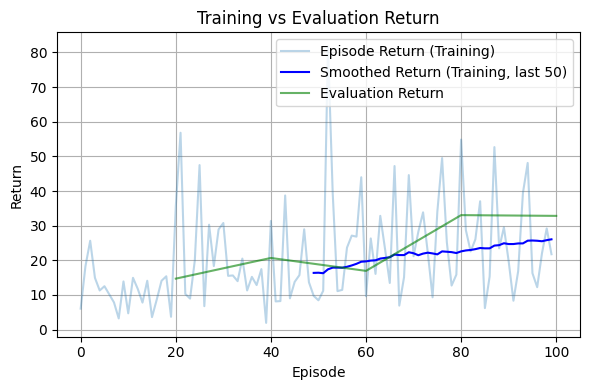

In [17]:
returns_plot_name = f"training_vs_evaluation_return{N_episodes}"
plot_returns(train_rewards_list, eval_rewards_list, smooth_over=50, eval_every=20, plot_name=returns_plot_name)

In [20]:
def plot_losses(losses, window, plot_name):
    """Plot the training losses."""
    
    plt.figure(figsize=(6, 4))
    
    # loss curve
    plt.plot(losses, label="Raw Loss", alpha=0.4)

    # Smoothed loss curve
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, window-1 + len(smoothed_losses)), smoothed_losses, label=f"Smoothed (window={window})", linewidth=2)

    plt.xlabel("Update Step")
    plt.ylabel("Loss")
    plt.title("Loss During Training")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join("plots", "losses", plot_name + ".png"))
    plt.show()

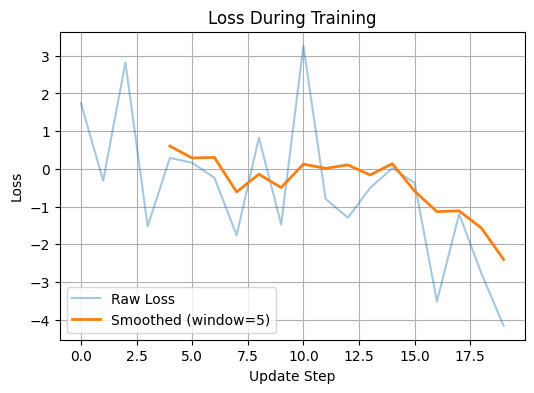

In [21]:
losses_plot_name = f"loss_evaluation{N_episodes}"
plot_losses(losses, window=5, plot_name=losses_plot_name)

After training and evaluating, we can test our trained agent behaviour. To do so, we run an episode using the below function.

In [22]:
def run_one_episode(env, agent, display=True):
    """Run one episode of the environment with the agent."""
    
    display_env = deepcopy(env)
    done = False
    truncated = False
    state, _ = display_env.reset()
    rewards = 0

    while not done and not truncated:
        action = agent.get_action(state, epsilon=0)
        state, reward, done, truncated, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
            
    if display:
        display_env.close()
        
    print(f'Sum of rewards {rewards}')

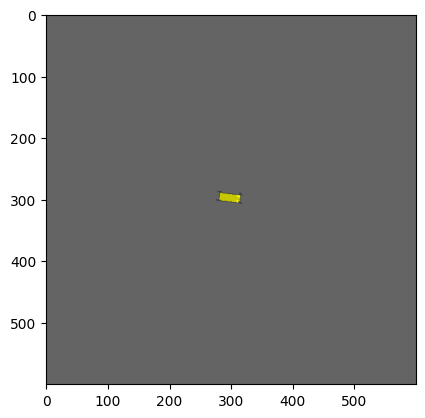

Sum of rewards 22.01889795435969


In [25]:
run_one_episode(env, agent, display=True)

When the behaviour of the agent is satistying, we save a version of the trained agent in a pickle file. That why, we can upload it whenever we want.

In [26]:
policy_name = "policy"
policy_file = os.path.join("policies", policy_name + ".pth")

torch.save(agent.policy_net.state_dict(), policy_file)

In [27]:
agent2 = reinforce.REINFORCEContinuous(action_space, 
                                       observation_space, 
                                       gamma, 
                                       episode_batch_size, 
                                       learning_rate
                                       )
agent2.policy_net.load_state_dict(torch.load(policy_file))

Using device: cuda


<All keys matched successfully>

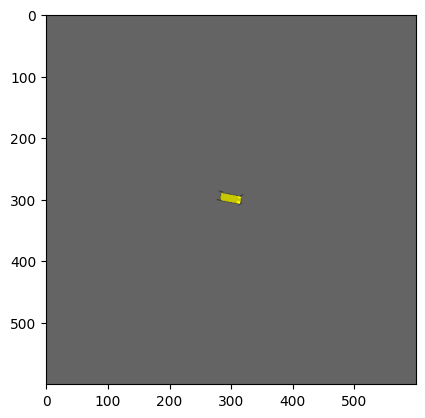

Sum of rewards 4.055319330833026


In [28]:
run_one_episode(env, agent2, display=True)

----

To make our experiments in task 4, we changed the hyperparameters but also the environment configuration. 

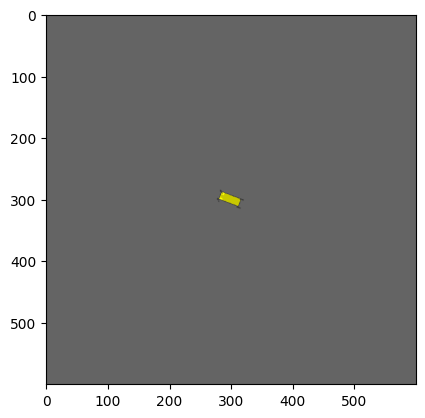

Sum of rewards 8.336961580969007


In [30]:
# config["action"]["longitudinal"] = True
# config["other_vehicles"] = 4  # we also test 6 and 9
config["controlled_vehicles"] = 2

env = gym.make("racetrack-v0", config=config, render_mode="rgb_array")
vec_env = make_vectorised_env("racetrack-v0", config=config, n_envs=n_eval)

agent2 = reinforce.REINFORCEContinuous(action_space, 
                                       observation_space, 
                                       gamma, 
                                       episode_batch_size, 
                                       learning_rate,
                                       net_hidden_size
                                       )

run_one_episode(env, agent2, display=True)

In [33]:
# we run 10 episodes to see the average agent performance
print("\nRunning 10 episodes")
rewards = eval_agent(agent2, env)
print("Collected rewards :", rewards)
print(f'Average over 10 runs : {np.mean(rewards)}')


Running 10 episodes
Collected rewards : [11.49545625 10.62531776 40.98198754 16.86574006  4.27629423  6.7807133
  1.23322565 16.87549545 10.52876967 21.44018363]
Average over 10 runs : 14.110318353479304
